# ONLY BUY or STAY

# import Library

In [1]:
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
from enum import Enum
import pandas as pd
import time
from collections import defaultdict
from collections import namedtuple
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import os
import io
import re
from collections import namedtuple
from collections import deque
import tensorflow as tf
from tensorflow.python import keras as K
from PIL import Image
import matplotlib.pyplot as plt
import random

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Load DF

In [2]:
class DataFramePreProcessing():

    
    def __init__(self, path_, is_daw=False):
        self.path_ = path_
        self.is_daw = is_daw

        
    def load_df(self):
        if self.is_daw:
            d='d'
        else:
            d=''
        FILE = glob.glob(self.path_)
        df = pd.read_csv(FILE[0])
        df = df.rename(columns={df.columns[0]:'nan',df.columns[1]:'nan',df.columns[2]:'nan',\
                                    df.columns[3]:'day',df.columns[4]:'nan',df.columns[5]:d+'open',\
                                    df.columns[6]:d+'high',df.columns[7]:d+'low',df.columns[8]:d+'close',\
                                       df.columns[9]:d+'volume',})
        df = df.drop('nan',axis=1)
        df = df.drop(df.index[0])
        df['day'] = pd.to_datetime(df['day'],format='%Y/%m/%d')
        df.set_index('day',inplace=True)

        return df.astype(float)

# Experience class

In [3]:
Experience = namedtuple("Experience", ["s","a","r","n_s","d"])

# Action class

In [12]:
class Action(Enum):
    BUY  = 0
    STAY = 1

# Environment class    

In [35]:
class Environment():
    
    
    def __init__(self, x_train, price_chart):
        self.x_train = x_train # state list
        self.time = 0 # x_trainのindex
        self.price_chart = price_chart
        
        
    def reset(self):
        self.time=0
        return self.x_train.iloc[self.time].tolist()
        
    
    def actions(self):
        return [Action.BUY, Action.STAY]
    
    
    
    def state(self):
        return self.x_train.iloc[self.time].tolist()
  
            
    def reward_func(self, action):
        reward=0
        done = False

        if self.time >= len(self.price_chart)-2: 
            done = True
   
        if action==Action.BUY:
            reward=self.price_chart['close'].iloc[self.time+1]-self.price_chart['open'].iloc[self.time+1]

        elif action==Action.STAY:
            reward=0

            
        return reward, done
            
    
    
    def step(self, action):
        reward, done = self.reward_func(action)
        self.time += 1
        next_state = self.state()
        
    
        return next_state, reward, done
        
        
        
    
    

# Agent class

In [36]:
class FNAgent():
    
    
    def __init__(self, epsilon, actions):
        self.epsilon = epsilon
        self.actions = actions
        self.model = None
        self.estimate_probs = False
        self.initialized = False
        
        
    def save(self, model_path):
        self.model.save(model_path, overwrite=True, include_optimizer=False)
        
        
    def policy(self, s):# 買ってたら戦略が変わる

        if np.random.random() < self.epsilon or not self.initialized:
            return np.random.randint(len(self.actions))
        else:
            estimates = self.estimate(s)
            if self.estimate_probs:
                return np.random.choice(self.actions,size=1, p=estimates)[0]
            else:
                return np.argmax(estimates)
        
    @classmethod
    def load(cls, env, model_path, epsilon=0.0001):
        actions = list(range(len(Action)))
        agent = cls(epsilon, actions)
        agent.model = K.models.load_model(model_path)
        agent.initialized = True
        return agent
    
    
    def initialize(self, experiences):
        pass
        
        
    def estimate(self, s):
        pass
        
        
    def update(self, experiences, gamma):
        pass
        
        
    def play(self, env, episode_count=10):
        actions = env.actions()
        
        for e in range(episode_count):
            print("==================")
            print("episode :",e)
            s = env.reset()
            done = False
            total_reward = 0
            reward_log = []
            
            is_start = False
            is_end = False
           
                
            

            while not done:
                a = self.policy(s)
                action = actions[a]
                n_state, reward, done = env.step(action)
                total_reward += reward
                s = n_state
                reward_log.append(total_reward)
                
            else:
                
                print("Get reward {}.".format(total_reward))
                plt.plot(reward_log)
                plt.show()

# Trainer class

In [37]:
class Trainer():

    
    def __init__(self, buffer_size=1024, batch_size=32,gamma=0.9):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.experiences = deque(maxlen=buffer_size)
        self.training = False
        self.training_count = 0
        

    def train_loop(self, env, agent, episode=200, initial_count=-1):
        self.experiences = deque(maxlen=self.buffer_size)
        self.training = False
        self.training_count = 0
        actions = env.actions()
        reward_log = []
        
        for i in range(episode):
            s = env.reset()
            done = False
            step_count = 0
            self.episode_begin(i, agent)
            total_rewards = 0
            
            if i%10==0:
                print("----------------------")
                print("episode :",i)
            
            while not done:
                

                a = agent.policy(s)
                action = actions[a]
                n_state, reward, done = env.step(action)
                e = Experience(s, a, reward, n_state, done)
                total_rewards += reward
                self.experiences.append(e)
                
                
                if not self.training and len(self.experiences) == self.buffer_size:
                    self.begin_train(i, agent)
                    self.training = True
                
                # step -> update if training==True
                self.step(i, step_count, agent, e)

                s = n_state
                step_count += 1
            else:
#                 self.episode_end(i, step_count, agent)
                
                reward_log.append(total_rewards)
                if not self.training and initial_count > 0 and i >= initial_count:
                    self.begin_train(i, agent)
                    self.training = True


                if self.training:
                    self.training_count += 1
                    
            
        plt.plot(reward_log)
        plt.show()
        

    
    def episode_begin(self, episode, agent):
        pass

    
    def begin_train(self, episode, agent):
        pass

    
    def step(self, episode, step_count, agent, experience):
        pass

    
    def episode_end(self, episode, step_count, agent):
        pass

    
    def is_event(self, count, interval):
        return True if count != 0 and count % interval == 0 else False

    
    def get_recent(self, count):
        recent = range(len(self.experiences) - count, len(self.experiences))
        return [self.experiences[i] for i in recent]



# Value function Agent class

In [38]:
class ValueFunctionAgent(FNAgent):

    
    def save(self, model_path):
        joblib.dump(self.model, model_path)

    
    @classmethod
    def load(cls, env, model_path, epsilon=0.0001):
        actions = list(range(len(Action)))
        agent = cls(epsilon, actions)
        agent.model = joblib.load(model_path)
        agent.initialized = True
        return agent

    
    def initialize(self, experiences):
        scaler = StandardScaler() # 特徴料(列)ごとに標準化してる
        estimator = MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=1)
        self.model = Pipeline([("scaler", scaler), ("estimator", estimator)])

        states = np.vstack([e.s for e in experiences])
        self.model.named_steps["scaler"].fit(states)

        # Avoid the predict before fit.
        self.update([experiences[0]], gamma=0)
        self.initialized = True
        print("Done initialization. From now, begin training!")

    
    def estimate(self, s):
        s = np.array(s).reshape(1,-1)
        estimated = self.model.predict(s)[0]
        return estimated

    
    def _predict(self, states):
        if self.initialized:
            predicteds = self.model.predict(states)
        else:
            size = len(self.actions) * len(states)
            predicteds = np.random.uniform(size=size)
            predicteds = predicteds.reshape((-1, len(self.actions)))
        return predicteds

    
    def update(self, experiences, gamma):
        states = np.vstack([e.s for e in experiences])
        n_states = np.vstack([e.n_s for e in experiences])

        estimateds = self._predict(states)
        future = self._predict(n_states)


        for i, e in enumerate(experiences):
            reward = e.r
            if not e.d:
                reward += gamma * np.max(future[i])
            estimateds[i][e.a] = reward

        estimateds = np.array(estimateds)
        states = self.model.named_steps["scaler"].transform(states)
        self.model.named_steps["estimator"].partial_fit(states, estimateds)


# Value function Trainer

In [58]:
class ValueFunctionTrainer(Trainer):

    
    def train(self, env, episode_count=250, epsilon=0.1, initial_count=-1):
        actions = list(range(len(Action)))
        agent = ValueFunctionAgent(epsilon, actions)
        self.train_loop(env, agent, episode_count, initial_count)
        return agent

   
    def begin_train(self, episode, agent):
        agent.initialize(self.experiences)

    
    def step(self, episode, step_count, agent, experience):
        if self.training:
            batch = random.sample(self.experiences, self.batch_size)
            agent.update(batch, self.gamma)
      
    
    def episode_end(self, episode, step_count, agent):
#         rewards = [e.r for e in self.get_recent(step_count)]
        pass
        

# main

----------------------
episode : 0
Done initialization. From now, begin training!
----------------------
episode : 10
----------------------
episode : 20
----------------------
episode : 30
----------------------
episode : 40
----------------------
episode : 50
----------------------
episode : 60
----------------------
episode : 70
----------------------
episode : 80
----------------------
episode : 90
----------------------
episode : 100
----------------------
episode : 110
----------------------
episode : 120
----------------------
episode : 130
----------------------
episode : 140
----------------------
episode : 150
----------------------
episode : 160
----------------------
episode : 170
----------------------
episode : 180
----------------------
episode : 190
----------------------
episode : 200
----------------------
episode : 210
----------------------
episode : 220
----------------------
episode : 230
----------------------
episode : 240


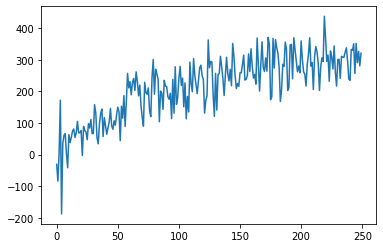

episode : 0
Get reward -35.0.


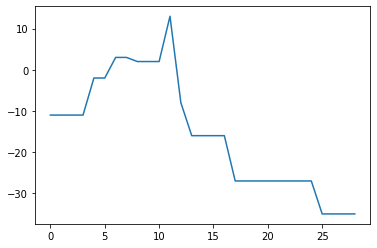

episode : 1
Get reward -33.0.


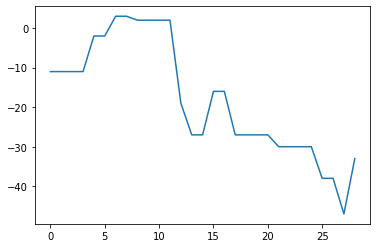

episode : 2
Get reward -33.0.


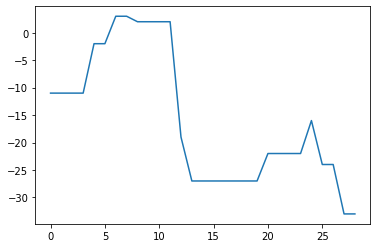

episode : 3
Get reward -57.0.


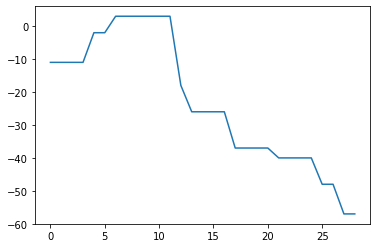

episode : 4
Get reward -54.0.


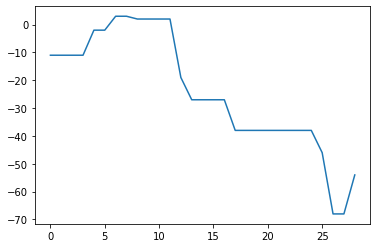

episode : 5
Get reward -33.0.


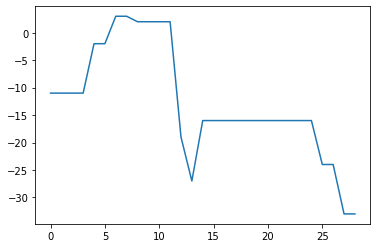

episode : 6
Get reward -55.0.


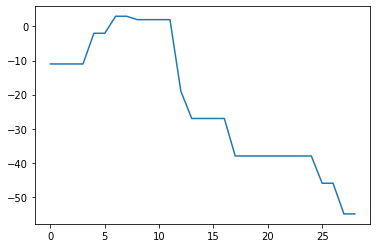

episode : 7
Get reward -55.0.


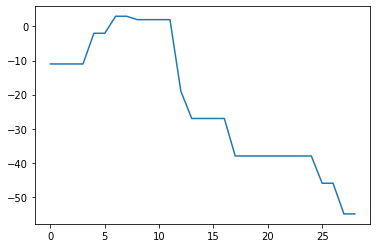

episode : 8
Get reward -55.0.


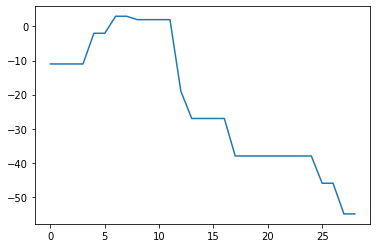

episode : 9
Get reward -38.0.


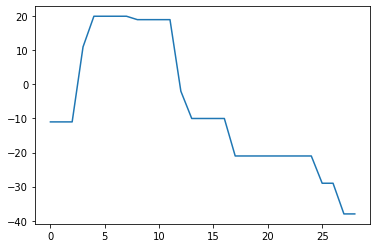

In [59]:
test_rate = 0.9
n_divide = 10

x_train, price_chart = make_x_train(path_tpx)

a_year = len(x_train)//n_divide

start1 = (n_divide-1)*a_year
end1  = start1 + int(a_year*test_rate)
start2 = end1


s_train = x_train.iloc[start1 : end1]
s_test = x_train.iloc[start2:]
price_train = price_chart.iloc[start1 : end1]
price_test  = price_chart.iloc[start2:]


env_train = Environment(s_train,price_train)
env_test = Environment(s_test,price_test)
trainer = ValueFunctionTrainer()
trained = trainer.train(env_train)   
trained.play(env_test)

In [408]:
env_train.price_chart.index[100]

Timestamp('2020-11-19 00:00:00')

# make x_train price_chart

In [49]:
path_tpx = '/Users/rince/Desktop/StockPriceData/Stock_index/TOPIX_10years.csv'


def make_x_train(path_):
    
    
    path_daw = '/Users/rince/Desktop/StockPriceData/Stock_index/DAW_10years.csv'


    df_tpx  = DataFramePreProcessing(path_).load_df()
    df_daw = DataFramePreProcessing(path_daw, is_daw=True).load_df()
    daw_p = df_daw['dclose'].pct_change()
    tpx_p = df_tpx['close'].pct_change()
    df_con = pd.concat([daw_p,tpx_p],axis = 1,join='inner').astype(float)
    
    df_tmp = df_con.rename(columns={'close': 'pclose'})
    df_tmp = pd.concat([df_tmp,df_tpx.loc[:,['open','close']]],axis = 1,join='inner').astype(float)
    
    x_train = df_tmp.loc[:,['dclose','pclose']].iloc[1:]
    price_chart = df_tmp.loc[:,['open','close']].iloc[1:]
    return x_train, price_chart


In [26]:
x_t, p_c = make_x_train(path_tpx)

In [27]:
p_c

,open,close
day,,
2011-06-24,852.0,859.0
2011-06-27,857.0,852.0
2011-06-28,857.0,855.0
2011-06-29,866.0,868.0
2011-06-30,874.0,874.0
...,...,...
2021-06-16,2069.0,2075.0
2021-06-17,2071.0,2063.0
2021-06-18,2063.0,2041.0


In [101]:
scaler = StandardScaler()
estimator = MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=1)
model = Pipeline([("scaler", scaler), ("estimator", estimator)])

# states = np.vstack([e.s for e in experiences])
# self.model.named_steps["scaler"].fit(states)

In [119]:
tmp = df_con.drop('dvolume',axis=1)
tmp
sample_data = tmp.iloc[-10:]

In [120]:
sample_data = np.array(sample_data.values.tolist())
scaler.fit(sample_data)


StandardScaler()

In [118]:
sample_data

(10, 9)

In [122]:
scaler.mean_

array([-1.87423419e-03, -1.87423419e-03, -1.87423419e-03, -1.87423419e-03,
       -6.67637461e-04, -4.12383761e-04, -8.44857532e-04, -1.58285951e-04,
        6.55099676e-01])